In [1]:
%%bash
LD_LIBRARY_PATH=/nas/longleaf/rhel8/apps/cuda/lib64:$PATH:$LD_LIBRARY_PATH
export LD_LIBRARY_PATH
XLA_FLAGS=--xla_gpu_cuda_data_dir=/nas/longleaf/rhel8/apps/cuda/11.8
export XLA_FLAGS

In [2]:
import os

from xml.etree import ElementTree
import glob
from tensorflow import keras
import tensorflow as tf
import sklearn
from skimage import draw
from skimage.io import imread
from skimage import morphology
from skimage import transform
from skimage import util
import numpy as np
from matplotlib import pyplot
#from tensorflow import keras
#import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Model
from tensorflow.keras.utils import  plot_model
tf.keras.backend.set_image_data_format('channels_last')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
et = ElementTree.parse("../proboscis_annotations_big.xml")

In [5]:
image_names = sorted(glob.glob("../big/*.png"))
image_names = list(map(lambda x: x.replace("\\", "/"), image_names))
image_names = list(map(lambda x: x[3:], image_names))
print(image_names)

['big/example0000000.png', 'big/example0000001.png', 'big/example0000002.png', 'big/example0000003.png', 'big/example0000004.png', 'big/example0000005.png', 'big/example0000006.png', 'big/example0000007.png', 'big/example0000008.png', 'big/example0000009.png', 'big/example0000010.png', 'big/example0000011.png', 'big/example0000012.png', 'big/example0000013.png', 'big/example0000014.png', 'big/example0000015.png', 'big/example0000016.png', 'big/example0000017.png', 'big/example0000018.png', 'big/example0000019.png', 'big/example0000020.png', 'big/example0000021.png', 'big/example0000022.png', 'big/example0000023.png', 'big/example0000024.png', 'big/example0000025.png', 'big/example0000026.png', 'big/example0000027.png', 'big/example0000028.png', 'big/example0000029.png', 'big/example0000030.png', 'big/example0000031.png', 'big/example0000032.png', 'big/example0000033.png', 'big/example0000034.png', 'big/example0000035.png', 'big/example0000036.png', 'big/example0000037.png', 'big/exampl

In [6]:
masks = {}
for img in et.findall('image'):
    width = int(img.attrib['width']) + 1
    height = int(img.attrib['height']) + 1
    blank = np.zeros(shape=(height,width),dtype=np.uint8)
    polys = img.findall('polyline')
    for poly in polys:
        attribs = poly.attrib
        pstr = attribs['points']
        pairs = pstr.split(';')
        coord_list = []
        for pair in pairs:
            xstr,ystr = pair.split(',')
            x = float(xstr)
            y = float(ystr)
            coord_list.append((x,y))
        for i in range(len(coord_list) - 1):
            start = coord_list[i]
            end = coord_list[i + 1]
            line = draw.line(round(start[1]),round(start[0]),round(end[1]),round(end[0]))
            blank[line] = np.uint8(255)
    masks[img.attrib['name']] = blank > 0

In [7]:
!pip freeze | grep 'scikit-image'

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
images = {}
for name in image_names:
    data = imread("../" + name)

    images[name] = data

In [9]:
names = [image_name[4:] for image_name in image_names]
print(names)

['example0000000.png', 'example0000001.png', 'example0000002.png', 'example0000003.png', 'example0000004.png', 'example0000005.png', 'example0000006.png', 'example0000007.png', 'example0000008.png', 'example0000009.png', 'example0000010.png', 'example0000011.png', 'example0000012.png', 'example0000013.png', 'example0000014.png', 'example0000015.png', 'example0000016.png', 'example0000017.png', 'example0000018.png', 'example0000019.png', 'example0000020.png', 'example0000021.png', 'example0000022.png', 'example0000023.png', 'example0000024.png', 'example0000025.png', 'example0000026.png', 'example0000027.png', 'example0000028.png', 'example0000029.png', 'example0000030.png', 'example0000031.png', 'example0000032.png', 'example0000033.png', 'example0000034.png', 'example0000035.png', 'example0000036.png', 'example0000037.png', 'example0000038.png', 'example0000039.png', 'example0000040.png', 'example0000041.png', 'example0000042.png', 'example0000043.png', 'example0000044.png', 'example0

In [10]:
pairs = []
cross = zip(image_names, image_names)
for short_name, long_name in cross:
    if short_name in masks:
        mask = masks[short_name]
        trainee = images[long_name]
        pairs.append((trainee, morphology.dilation(mask[:-1,:-1])))
    else:
        trainee = images[long_name]
        mask = np.zeros(shape=trainee.shape)
        pairs.append((trainee, mask))

In [11]:
len(pairs)

373

In [12]:
with_probs = filter(lambda pair : pair[1].sum() > 0, pairs)

In [13]:
labeled_pairs = list(with_probs)

In [14]:
len(labeled_pairs)

350

In [15]:
inputs = []
outputs = []
for my_in, my_out in labeled_pairs:
    inputs.append(my_in)
    outputs.append(my_out)

In [16]:
ins = np.array(inputs)
outs = np.array(outputs)

In [17]:
ins.shape

(350, 600, 100)

In [18]:
outs.shape

(350, 600, 100)

In [19]:
input_data = ins[..., np.newaxis]
output_data = outs[..., np.newaxis]

In [20]:
# from https://blog.paperspace.com/unet-architecture-image-segmentation/

def convolution_block(input_lay, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(input_lay)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(bn1)
    
    conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(act1)
    bn2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(bn2)
    
    return act2

def encoder(input_lay, filters=64):
    enc1 = convolution_block(input_lay, filters)
    max_pool1 = layers.MaxPooling2D()(enc1)
    return enc1, max_pool1

def decoder(input_lay, skip_lay, filters=64):
    upsample = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(input_lay)
    connect_skip = layers.Concatenate()([upsample, skip_lay])
    out = convolution_block(connect_skip, filters)
    return out

def u_net(image_size):
    input1 = layers.Input(image_size)
    
    skip1, enc1 = encoder(input1, 64)
    skip2, enc2 = encoder(enc1, 64 * 2)
    skip3, enc3 = encoder(enc2, 64 * 4)
    skip4, enc4 = encoder(enc3, 64 * 8)
    
    conv_block = convolution_block(enc4, 64*16)
    
    dec1 = decoder(conv_block, skip4, 64 * 8)
    dec2 = decoder(dec1, skip3, 64 * 4)
    dec3 = decoder(dec2, skip2, 64 * 2)
    dec4 = decoder(dec3, skip1, 64)
    
    out = layers.Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(dec4)
    
    model = Model(input1, out)
    
    return model

inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)
skip2, enc2 = encoder(enc1, 64 * 2)
#skip3, enc3 = encoder(enc2, 64 * 4)

conv_block = convolution_block(enc2, 64 * 4)

dec1 = decoder(conv_block, skip2, 64 * 2)
dec2 = decoder(dec1, skip1, 64)
#dec3 = decoder(dec2, skip1, 64)

f = layers.Flatten()(dec2)

#out = layers.Dense(1)(f)
out = layers.Conv2D(filters=1, kernel_size=(1,1))(dec2)

model = Model(inp, out)
model.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam())
#plot_model(model)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 100, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 600, 100, 64  640         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
import math

class ImageSeq(keras.utils.Sequence):
    
    def __init__(self, ins: np.ndarray, outs: np.ndarray, batch=32):
        assert ins.shape == outs.shape
        self.inputs = np.copy(ins)
        self.outputs = np.copy(outs)
        self.batch = batch
    
    def __len__(self):
        return math.ceil(len(self.inputs) / self.batch)
    
    def __getitem__(self, idx):
        i = self.inputs[idx * self.batch : (idx + 1) * self.batch]
        o = self.outputs[idx * self.batch : (idx + 1) * self.batch]
        return i.astype(np.uint8), o
    

class RepeatSeq(keras.utils.Sequence):
    
    def __init__(self, wrapped, repeats :int):
        self.wrapped = wrapped
        self.repeats = repeats
    
    def __len__(self):
        return len(self.wrapped) * self.repeats
    
    def __getitem__(self, idx):
        rel_idx = idx % len(self.wrapped)
        i, o = self.wrapped[rel_idx]
        return np.copy(i), np.copy(o)
    
class RandomFlip(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.thresh = thresh
        self.should_flip = np.random.random(len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.should_flip[idx] > self.thresh:
            give_i = np.flip(give_i, axis=1)
            give_o = np.flip(give_o, axis=1)
        return give_i, give_o

class RandomXShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-20, 20, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[move, 0])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

class RandomYShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-200, 200, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[0, move])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

In [24]:
r = RandomXShift(RandomYShift(RandomFlip(RepeatSeq(ImageSeq(input_data, output_data, 1), 2))))

In [25]:
model.fit(r, epochs=40)

Epoch 1/40
700/700 [==============================] - 257s 347ms/step - loss: 0.0762
Epoch 2/40
160/700 [=====>........................] - ETA: 4:13 - loss: 0.0565

KeyboardInterrupt: 

In [54]:
model.save("proboscis_model_1")

INFO:tensorflow:Assets written to: proboscis_model_1\assets


INFO:tensorflow:Assets written to: proboscis_model_1\assets


In [55]:
a,b = r[0]

In [56]:
m = model(a)

In [57]:
n = m.numpy()

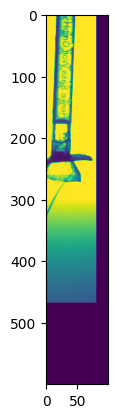

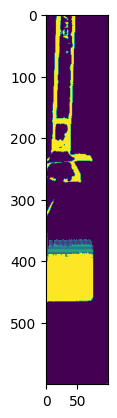

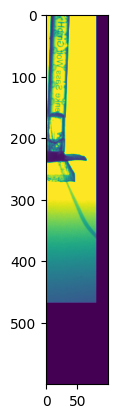

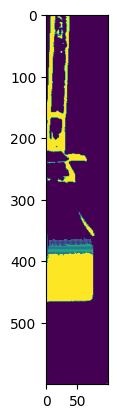

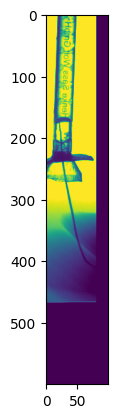

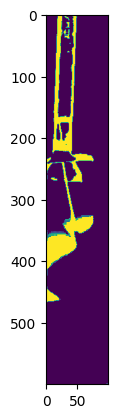

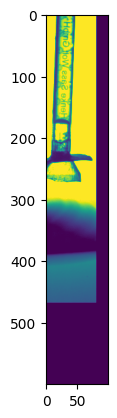

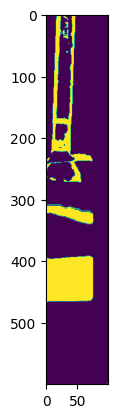

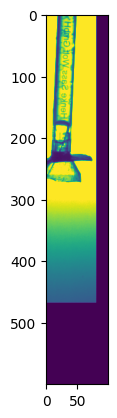

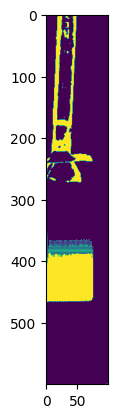

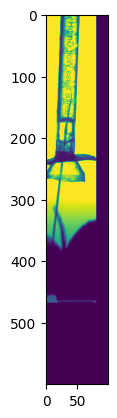

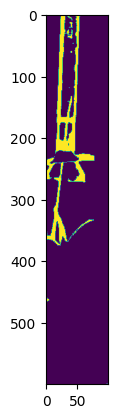

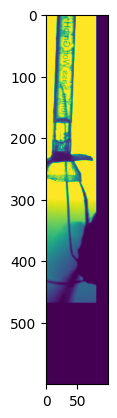

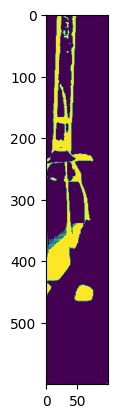

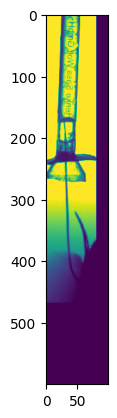

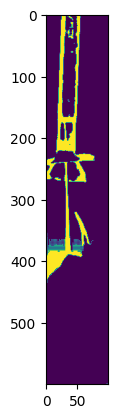

In [58]:
for i in range(8):
    pyplot.imshow(a[i,:,:,0])
    pyplot.show()
    pyplot.imshow(n[i,:,:,0] > 0)
    pyplot.show()

In [36]:
pyplot.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>